Messo in questa directory temporaneamente perchè non mi funziona l'import per la funzione *read_data*

In [293]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import os

import sklearn
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

In [294]:
X_LABEL = "X_LABEL"
Y_LABEL = "Y_LABEL"
LOG_SCALE = "LOG_SCALE"

def get_data_sorted(name, data):
    """
    Takes the dataset and the name of column on which it sorts
    return python, matlab dataset
    """
    data = data.sort_values(by=[name])  # sort sulle dimensioni delle matrici in ordine crescente
    data_python = data.loc[data['Language'] == 1]
    data_matlab = data.loc[data['Language'] == 0]
    return data_python, data_matlab


def read_data(name):
    from Analysis.resources.costants import RESOURCES_DIRECTORY
    path = os.path.join(RESOURCES_DIRECTORY, name)
    return pd.read_csv(path)


def write_data(df, name):
    from Analysis.resources.costants import RESOURCES_DIRECTORY
    path = os.path.join(RESOURCES_DIRECTORY, name)
    df.to_csv(path, index=False)

def plot(labels, data_py, data_matlab, x_name, y_name, title, legend1, legend2, **keywords):

    figure(figsize=(20, 6), dpi=80)
    title = title + " " + "(Line Plot)"

    plt.plot(labels, data_py, label=legend1, linestyle="-")
    plt.plot(labels, data_matlab, label=legend2, linestyle="--")
    show(x_name, y_name, title, **keywords)


def bar_plot(labels, data_py, data_matlab, x_name, y_name, title, legend1, legend2, **keywords):
    figure(figsize=(20, 6), dpi=80)
    title = title + " " + "(Bar Plot)"

    x_axis = np.arange(len(labels))

    # Multi bar Chart

    plt.bar(x_axis -0.2, data_py, width=0.4, label = legend1)
    plt.bar(x_axis +0.2, data_matlab, width=0.4, label = legend2)

    # Xticks

    plt.xticks(x_axis, labels)
    show(x_name, y_name, title, **keywords)



def show(x_name, y_name, title, **keywords):

    x_label, y_label = "", ""
    if X_LABEL in keywords.keys():
        x_label = f"({keywords[X_LABEL]})"
    if Y_LABEL in keywords.keys():
        y_label = f"({keywords[Y_LABEL]})"
    if LOG_SCALE in keywords.keys():
        plt.yscale('log') # logarithmic scale

    plt.xlabel(f"{x_name} {x_label}",  labelpad=15, fontsize=12, color="#333533")
    plt.ylabel(f"{y_name} {y_label}",  labelpad=15, fontsize=12, color="#333533")
    plt.title(title, fontsize=18, color="#333533", pad=35)

    # removing axes from the figure
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.legend(loc='upper center',ncol=2,frameon=False)
    plt.show()


def correlation(x, y, x_name, y_name):
    figure(figsize=(20, 6), dpi=80)
    title = f"Scatter-plot variables '{x_name}' and '{y_name}'"
    my_rho = np.corrcoef(x, y) # Correlation Coefficient
    print(my_rho)

    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)

    # Creatoing a linear regression model and fitting the data to the model
    model = LinearRegression()
    model.fit(x, y)

    # Now, predicting the y values according to the model
    y_line = model.predict(x)

    # Printing thr coffecient/parameter of the resulted line
    print(f"The parameters of the line: {model.coef_}")

    # Plotting the data points and the best fit line
    plt.scatter(x, y)
    plt.plot(x, y_line, 'r', label=f"Correlation Coefficient {my_rho[0][1]}")
    show(x_name, y_name, title)




In [295]:
data = pd.read_csv("data.csv")

# drops rows with duplicat Name, since conditioning and nnz is the same
unique_data = data.drop_duplicates(subset='Name', keep="first")
unique_data


,Name,Rows,Columns,Error,Memory,Time,Language,OS,Nnz,Cond
0,apache2,715176,715176,2.235941e-08,0.004471,66.232192,1,0,4817870,5.316861e+06
4,cfd1,70656,70656,6.628463e-12,0.003326,4.461982,1,0,1825580,1.335081e+06
8,cfd2,123440,123440,1.334161e-10,0.003326,10.917099,1,0,3085406,3.728473e+06
12,ex15,6867,6867,5.281170e-05,0.003326,0.015078,1,0,98671,1.432642e+13
16,G3_circuit,1585478,1585478,3.452568e-09,210.620559,27.939265,1,0,7660826,2.238425e+07
20,parabolic_fem,525825,525825,8.836779e-10,0.003326,6.439602,1,0,3674625,2.110820e+05
24,shallow_water1,81920,81920,6.923992e-14,9.067514,0.615064,1,0,327680,3.628000e+00


Il file *data_aggregation.csv* contiene un'aggregazione dei dati delle matrici, con le proprietà fisse che restano invariate, mentre time, memory ed error, che variano a seconda di OS e linguaggio, vengono aggregate attraverso una media separata tra i due linguaggi di programmazione, calcolata sia per MATLAB che per Python. Vengono quindi aggregati i dati dei diversi OS, oltre che erchè molto simili, anche per risparmiare nel numero di colonne, essendo già di più delle righe

Ne scaturisce una tabella di 7 righe: una per ciascuna matrice, senza righe duplicate

Sarà utile in seguito per alcune analisi effettuate, soprattuto il clustering

In [296]:
data = pd.read_csv("data.csv")
unique_data = data.drop_duplicates(subset='Name', keep="first")
matrix_names = unique_data.Name.tolist()
agg_data = pd.DataFrame(columns=["Name", "Rows", "errorMat", "errorPy", "memoryMat", "memoryPy", "timeMat", "timePy", "Nnz", "Cond"])

for i in range(len(matrix_names)):
    name = unique_data.iloc[i].Name     # name of the i-th matrix
    
    sub_data_mat = data[(data.Name == name) & (data.Language == 0)]     # df of 2 rows for the current matrix in MATLAB
    sub_data_py = data[(data.Name == name) & (data.Language == 1)]      # df of 2 rows for the current matrix in Python

    error_mat = sub_data_mat["Error"].mean()      # error average just for MATLAB
    error_py = sub_data_py["Error"].mean()        # error average just for Python

    memory_mat = sub_data_mat["Memory"].mean()      # memory average just for MATLAB
    memory_py = sub_data_py["Memory"].mean()        # memory average just for Python

    time_mat = sub_data_mat["Time"].mean()      # time average just for MATLAB
    time_py = sub_data_py["Time"].mean()        # time average just for Python

    agg_data.loc[i] = [unique_data.iloc[i].Name, unique_data.iloc[i].Rows, error_mat, error_py, memory_mat, memory_py, 
                        time_mat, time_py, unique_data.iloc[i].Nnz, unique_data.iloc[i].Cond]

agg_data.to_csv("data_aggregation.csv", index=False)
agg_data

,Name,Rows,errorMat,errorPy,memoryMat,memoryPy,timeMat,timePy,Nnz,Cond
0,apache2,715176,4.388900e-11,2.235941e-08,2823.50505,65.695641,14.288000,74.802496,4817870,5.316861e+06
1,cfd1,70656,1.135900e-13,6.628463e-12,569.08860,24.734949,2.640650,4.922319,1825580,1.335081e+06
2,cfd2,123440,3.348600e-13,1.334161e-10,1166.58845,0.003326,6.162600,12.200138,3085406,3.728473e+06
3,ex15,6867,6.348200e-07,5.281170e-05,1.80840,1.333975,0.027761,0.018617,98671,1.432642e+13
4,G3_circuit,1585478,3.576600e-12,3.452568e-09,3233.09475,105.311943,19.193450,30.874976,7660826,2.238425e+07
5,parabolic_fem,525825,1.050000e-12,8.836779e-10,573.02630,0.003326,3.160100,7.180180,3674625,2.110820e+05
6,shallow_water1,81920,2.672800e-16,6.923992e-14,20.78310,4.535420,0.258710,0.680383,327680,3.628000e+00


# Come cresce l'Errore Relativo al crescere del Condizionamento?

Qui vengono mostrati Plot e Barplot, e successivamente nel dettaglio il cofficiente di correlazione, nelle 4 combinazioni linguaggio-OS 

(Terrei entrambe le tipologie di grafico per la documentazione Latex)

Come ci si poteva aspettare, la crescita dell'errore è direttamente proporzionale alla crescita del condizionamento della matrice: per questo ex15, pur essendo la matrice più piccola, è quella con errore più grande

(Dal momento che il condizionamento è stato calcolato su MATLAB, l'errore considerato è quello di MATLAB, OS Windows ma era indifferente dal momento che le analisi hanno evidenziato che gli errori non cambiano tra diversi OS)

/tmp/ipykernel_26779/2675366944.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_data.sort_values(by="Cond", inplace=True)


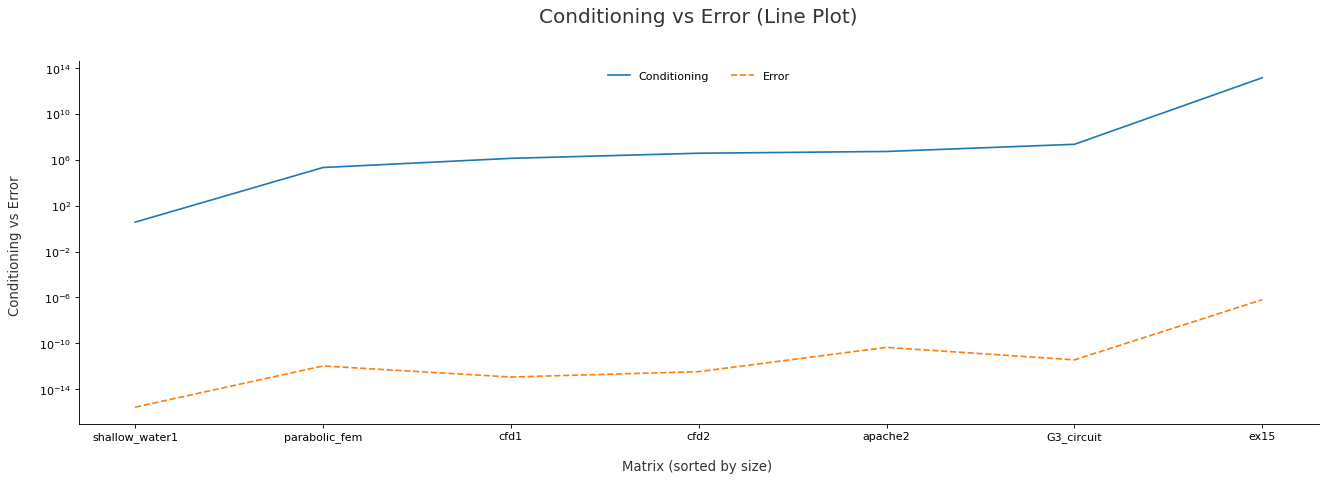

In [297]:
sub_data = data[(data.OS == 0) & (data.Language == 0)]

sub_data.sort_values(by="Cond", inplace=True)

cond_list = sub_data.Cond.tolist()
error_list = sub_data.Error.tolist()

matrix_names = sub_data.Name.tolist()

plot(matrix_names, cond_list, error_list, "Matrix (sorted by size)", "Conditioning vs Error", "Conditioning vs Error", "Conditioning", "Error", LOG_SCALE=True)

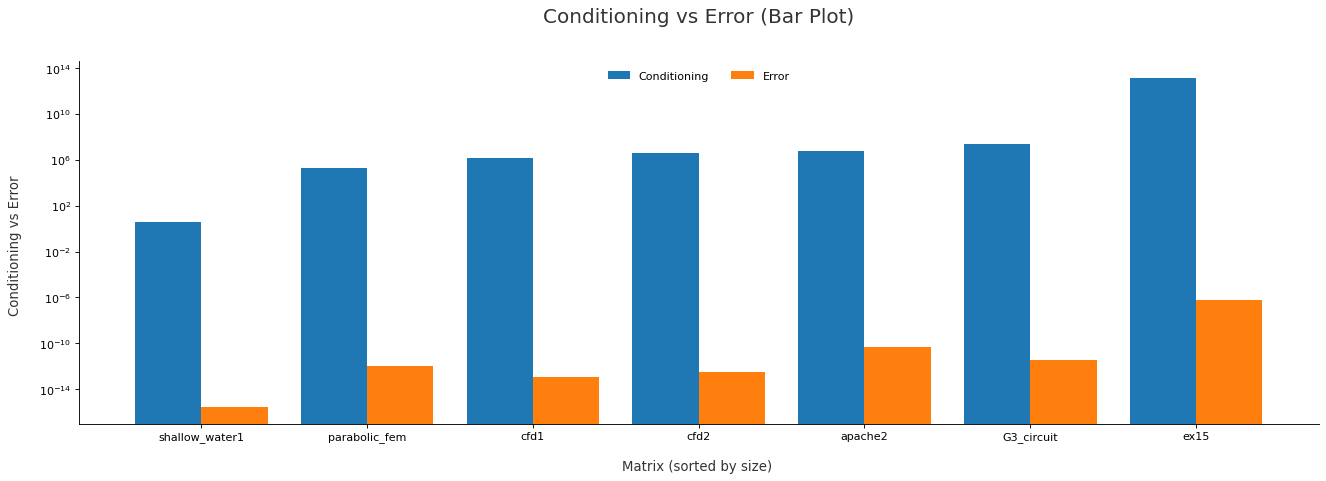

In [298]:
bar_plot(matrix_names, cond_list, error_list, "Matrix (sorted by size)", "Conditioning vs Error", "Conditioning vs Error", "Conditioning", "Error", LOG_SCALE=True)

## Coefficiente di Correlazione

0.92 per Python e 1 per MATLAB

Il Sistema Operativo non fa differenza

In [299]:
data = pd.read_csv("data.csv")
data.sort_values(by="Rows", ascending=True, inplace=True)

data_mat = data[data.Language == 0]
data_mat_win = data_mat[data_mat.OS == 0]
data_mat_lin = data_mat[data_mat.OS == 1]

data_py = data[data.Language == 1]
data_py_win = data_py[data_py.OS == 0]
data_py_lin = data_py[data_py.OS == 1]

[[1. 1.]
 [1. 1.]]
The parameters of the line: [[4.43105858e-20]]


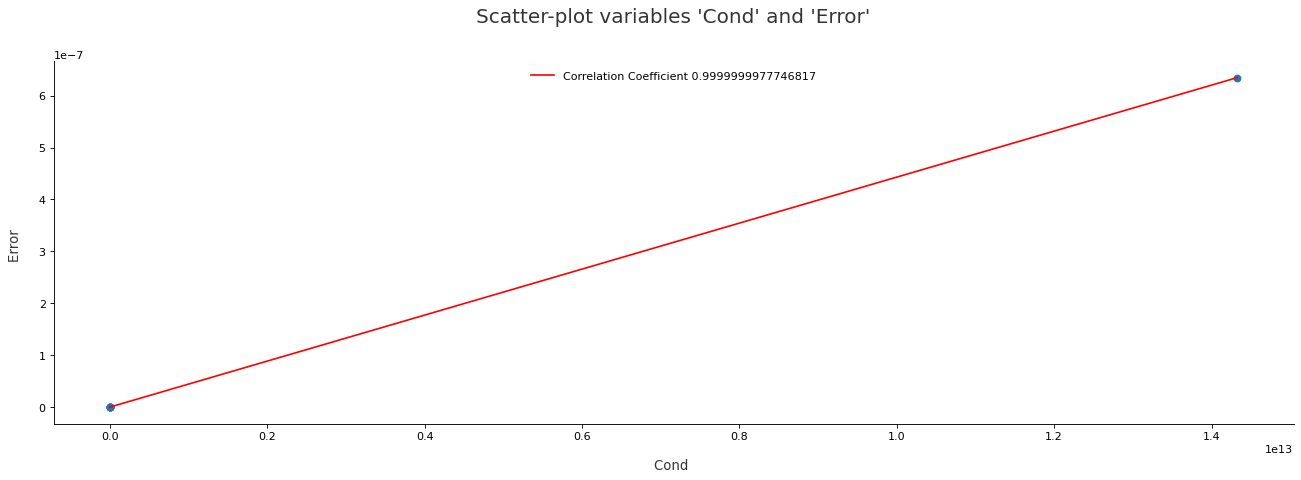

In [300]:
x = np.array(data_mat_lin['Cond'])
y = np.array(data_mat_lin['Error'])

correlation(x, y, "Cond", "Error")

[[1. 1.]
 [1. 1.]]
The parameters of the line: [[4.43105858e-20]]


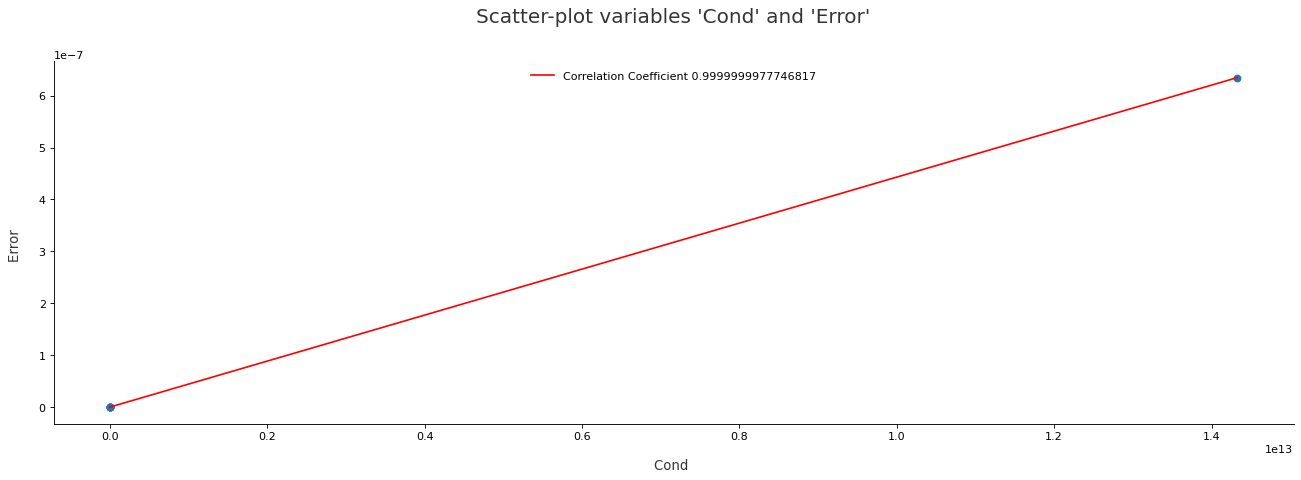

In [301]:
x = np.array(data_mat_win['Cond'])
y = np.array(data_mat_win['Error'])

correlation(x, y, "Cond", "Error")

[[1.         0.99999992]
 [0.99999992 1.        ]]
The parameters of the line: [[3.68600442e-18]]


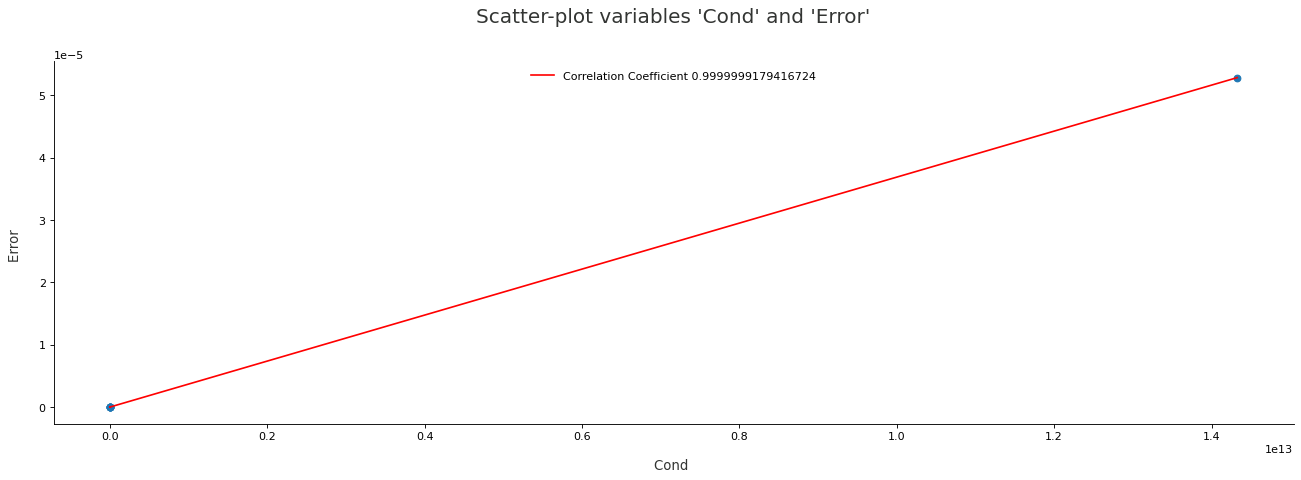

In [302]:
x = np.array(data_py_lin['Cond'])
y = np.array(data_py_lin['Error'])

correlation(x, y, "Cond", "Error")

[[1.         0.99999992]
 [0.99999992 1.        ]]
The parameters of the line: [[3.68600442e-18]]


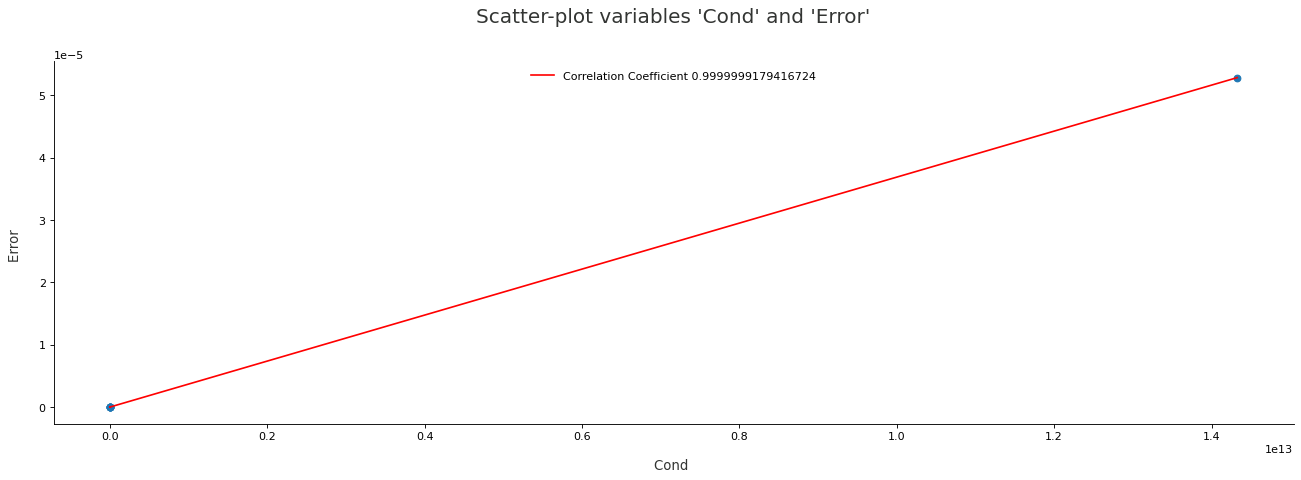

In [303]:
x = np.array(data_py_win['Cond'])
y = np.array(data_py_win['Error'])

correlation(x, y, "Cond", "Error")

# Come aumenta il tempo di esecuzione in relazione alla Densità della Matrice?

Dalle analisi precedenti è emerso come il tempo di esecuzione non dipenda solamente dalla dimensione della matrice, ma anche dalla forma che i dati al suo interno assumono: una matrice grande, i cui dati sono distribuiti attorno alla diagonale principale, richiede meno tempo di una più piccola, i cui dati sono però più dispersi

Con questa analisi l'obiettivo è quello di capire se questa distribuzione dei dati è esprimibile attraverso un valore numerico, e verrà quindi analizzato se c'è una correlazione causale tra la densità della matrice (data dal rapporto dei valori non-zeri e la dimensione dell'intera matrice) e il tempo di esecuzione necessario per applicarvi la decomposizione di Cholesky

Non sembra però esserci correlazione, come mostrano i valori (-0.42 per MATLAB e -0.37 per Python), il che è dovuto al fatto che le matrici più dense risultano essere proprio quelle di dimensioni minori, e pertanto richiedono tempo minore di esecuzione nonostante il rapporto di valori diversi da zero rispetto al totale è più alto in proporzione

In [304]:
# Calcolo densità matrici

matrix_names = agg_data.Name.tolist()

agg_data["Density"] = agg_data.Nnz / ((agg_data.Rows)**2)
agg_data.head(len(agg_data))

agg_data.sort_values(by="Density", inplace=True)

density_list = agg_data.Density.tolist()


# Tempi per MATLAB e Python

time_list_mat = agg_data.timeMat.tolist()
time_list_py = agg_data.timePy.tolist()

## MATLAB

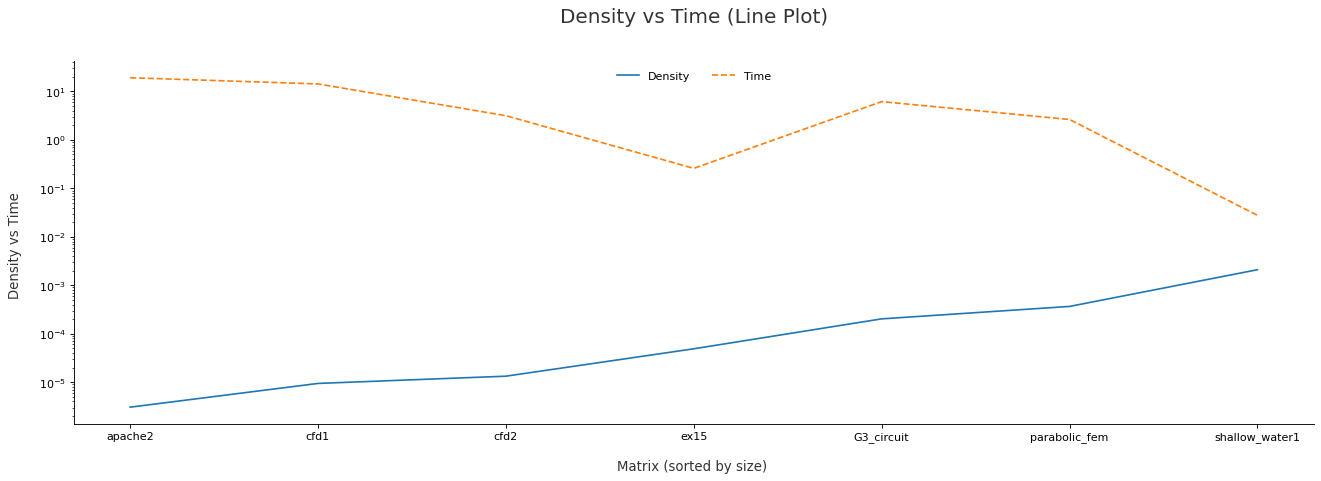

In [305]:
plot(matrix_names, density_list, time_list_mat, "Matrix (sorted by size)", "Density vs Time", "Density vs Time", "Density", "Time", LOG_SCALE=True)

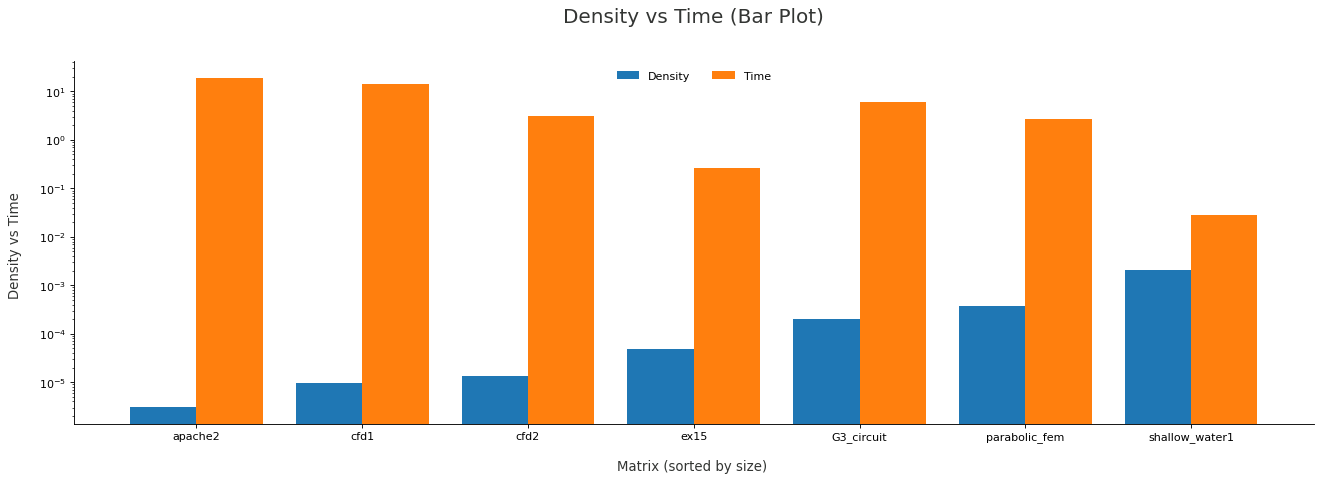

In [306]:
bar_plot(matrix_names, density_list, time_list_mat, "Matrix (sorted by size)", "Density vs Time", "Density vs Time", "Density", "Time", LOG_SCALE=True)

In [307]:
correlation(density_list, time_list_mat, "Cond", "Error")

[[ 1.         -0.45334827]
 [-0.45334827  1.        ]]


AttributeError: 'list' object has no attribute 'reshape'

<Figure size 1600x480 with 0 Axes>

## Python

In [ ]:
plot(matrix_names, density_list, time_list_py, "Matrix (sorted by size)", "Density vs Time", "Density vs Time", "Density", "Time", LOG_SCALE=True)

In [ ]:
bar_plot(matrix_names, density_list, time_list_py, "Matrix (sorted by size)", "Density vs Time", "Density vs Time", "Density", "Time", LOG_SCALE=True)

In [ ]:
correlation(density_list, time_list_py, "Cond", "Error")

In [ ]:
bar_plot(matrix_names, density_list, time_list_mat, "Matrix (sorted by size)", "Density vs Time", "Density vs Time", "Density", "Time", LOG_SCALE=True)

In [ ]:
correlation(density_list, time_list_mat, "Cond", "Error")

## Python

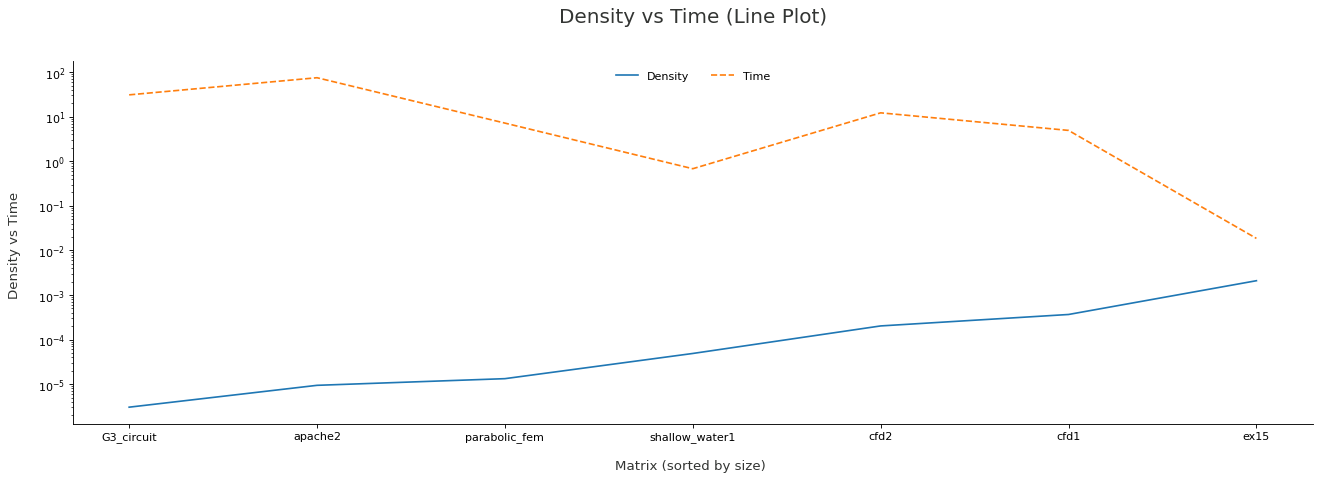

In [56]:
plot(matrix_names, density_list, time_list_py, "Matrix (sorted by size)", "Density vs Time", "Density vs Time", "Density", "Time", LOG_SCALE=True)

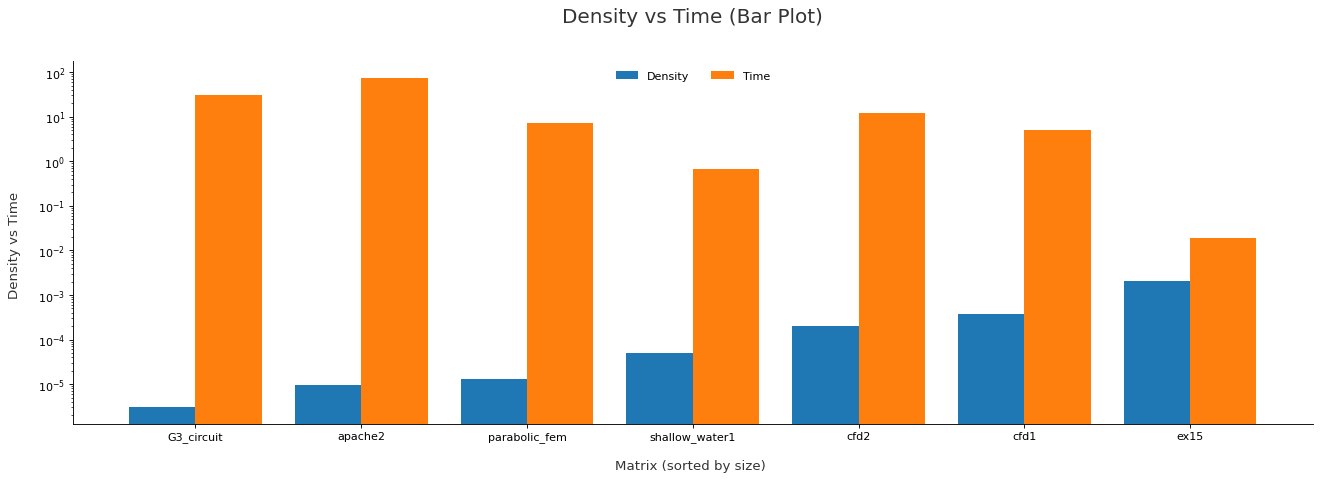

In [57]:
bar_plot(matrix_names, density_list, time_list_py, "Matrix (sorted by size)", "Density vs Time", "Density vs Time", "Density", "Time", LOG_SCALE=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[[ 1.         -0.37275857]
 [-0.37275857  1.        ]]


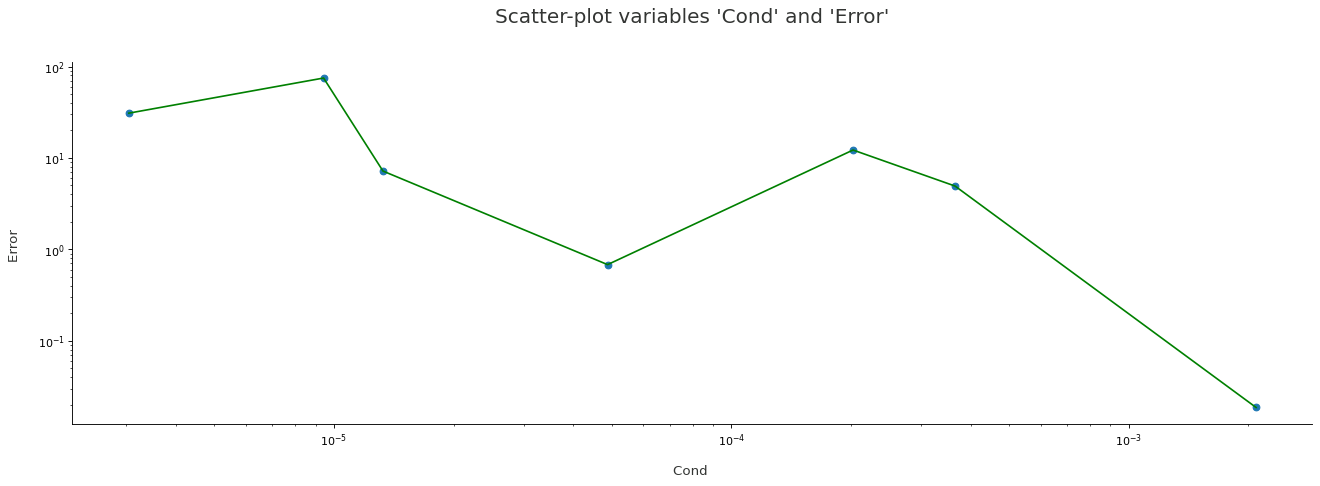

In [58]:
correlation(density_list, time_list_py, "Cond", "Error")

# Clustering delle Matrici

Tentativo di usare Clustering sulle matrici, per analizzare la suddivisione automatica scaturita da un k-means, con una conseguente interpretazione dei cluster scaturiti

L'algoritmo è stato provato sia con *k=3* che *k=4*, ma il secondo dà risultati più sensati

L'attributo Cond è stato rimosso, perchè sfasava tutto

**(Piccole)**: *ex15* ed *shallow_water* sono tra le più piccole, e inoltre hanno una forma simile, con i dati distribuiti attorno alla diagonale principale, quindi ci sta che siano insieme

**(Medie)**: *cfd1* e *cfd2* si trovano insieme, il che era prevedibile essendo due matrci molto simili, sia per dimensioni che forma

**(Grandi)**: *parabolic_fem* si trova isolata insieme ad *apache2*, il che va bene, dal momento che sono quelle con la forma più particolare, dimensioni simili 

**(Molto Grande)**: *G3* resta isolato, e ha senso perchè è la più grande, ha una forma particolare e poche proprietà in comune con le altre

Il clustering risultante sembra essere fatto molto bene, in quanto non si sofferma a classificare le matrici esclusivamente in base alla loro dimensione, ma tiene conto anche delle altre proprietà delle matrici, come dimostarto dal fatto che sebbene *cfd1* sia leggermente più piccola di *shallow_water*, si trova comunque nel cluster assieme alla matrice "sorella" *cfd2*


In [47]:
# Convert DataFrame to matrix
clustering_data = agg_data.drop(columns=['Name', 'Cond'])
mat = clustering_data.values

# Using sklearn
km = sklearn.cluster.KMeans(n_clusters=4)
km.fit(mat)

# Get cluster assignment labels
labels = km.labels_

# Format results as a DataFrame
agg_data["cluster"] = labels
agg_data.sort_values(by="cluster", inplace=True)
agg_data

,Name,Rows,errorMat,errorPy,memoryMat,memoryPy,timeMat,timePy,Nnz,Cond,cluster
4,G3_circuit,1585478,3.576600e-12,3.452568e-09,3233.09475,105.311943,19.193450,30.874976,7660826,2.238425e+07,0
2,cfd2,123440,3.348600e-13,1.334161e-10,1166.58845,0.003326,6.162600,12.200138,3085406,3.728473e+06,1
0,apache2,715176,4.388900e-11,2.235941e-08,2823.50505,65.695641,14.288000,74.802496,4817870,5.316861e+06,1
5,parabolic_fem,525825,1.050000e-12,8.836779e-10,573.02630,0.003326,3.160100,7.180180,3674625,2.110820e+05,1
3,ex15,6867,6.348200e-07,5.281170e-05,1.80840,1.333975,0.027761,0.018617,98671,1.432642e+13,2
6,shallow_water1,81920,2.672800e-16,6.923992e-14,20.78310,4.535420,0.258710,0.680383,327680,3.628000e+00,2
1,cfd1,70656,1.135900e-13,6.628463e-12,569.08860,24.734949,2.640650,4.922319,1825580,1.335081e+06,3
